# Hito 1: FL Intra-empresa

Se entrena un único modelo de manera federada para cada empresa. De esta forma, se mantendrá la privacidad de los datos de cada usuario y se medirá el rendimiento del modelo respecto a los baselines de sujetos individuales y empresa.

# Configuración del escenario mediante Flower

Se hará uso del modulo 'simulation' (version 0.18.0 de la libería) que elimina las restricciones de escalabilidad que se tenían respecto a versiones anteriores

Es necesario instalar Flower con el extra de 'simulation'

In [1]:
# !pip install -U flwr["simulation"]

Librerías empleadas para el Hito 1

In [2]:
import os
import math

# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import flwr as fl
import tensorflow as tf

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adadelta

from typing import Dict

from flwr.common.logger import log
from logging import INFO
from csv import writer

import matplotlib.pyplot as plt

Federated learning systems consist of a server and multiple clients.

In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

- `get_parameters`: Return the current local model parameters
- `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server 
- `evaluate`: Received model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use TensorFlow/Keras for the model training and evaluation. Keras models provide methods that make the implementation staightforward:
- we can update the local model with server-provides parameters through `model.set_weights`
- we can train/evaluate the model through `fit/evaluate`
- we can get the updated model parameters through `model.get_weights`.

In [3]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, model, x_train, y_train, x_val, y_val) -> None:
        self.cid = cid
        self.model = model
        self.x_train, self.y_train = x_train, y_train
        self.x_val, self.y_val = x_val, y_val

    def get_parameters(self):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        
        self.model.fit(self.x_train, self.y_train,
                       epochs=int(config["epochs"]),
                       batch_size=32,
                       verbose=0)
        
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        
        loss, acc = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        
        return loss, len(self.x_val), {"accuracy": acc, "client": self.cid}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. 

Federated learning systems have multiple clients, so each client will be represented by its own instance of `FlowerClient`.
- Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training 
- (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 21 clients on a single machine. This means that the server and all 21 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 21 clients would mean having 21 instances of `FlowerClient` im memory and 21 GRCP conections. **Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.**

In addition to the regular capabilities where server and clients run on multiple machines, **Flower therefore provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation**.

**To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand**. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` **or** `evaluate` (those instances are usually discarded after use).
- Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for each client

In [4]:
''' FUNCION PARA CARGAR LOS DATOS DE UN CLIENTE EN PARTICULAR '''
def prepare_model_data(client_file):
    df = pd.read_csv(client_file)
    
    train, test = train_test_split(df, test_size=0.30, random_state=42)
    
    X_train = train[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    X_test = test[['psd_delta', 'psd_theta', 'psd_alpha', 'psd_beta', 'psd_gamma','eog_blinks', 'eog_var']]
    y_train = train['y_class']
    y_test = test['y_class']
    
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

In [5]:
def client_fn(cid: str) -> fl.client.Client:
    
    # Model best hyperparameters (Ver notebook Hito0-Optimizacion-Baseline)
    neurons = 36
    activation = "relu"
    learning_rate = 0.180165
    optimizer = Adadelta(learning_rate=learning_rate)
    
    input_shape = (7,)
    
    # Create model
    model = Sequential()
    
    model.add(Dense(neurons, input_shape=input_shape, activation=activation))
    
    model.add(BatchNormalization())
        
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Load data partition
    base_path = "./data/horizontal/"
    path = f"{base_path}empresa_{(int(cid)%2)+1}/cliente_{cid}.csv"
    
    x_train_cid, x_val_cid, y_train_cid, y_val_cid = prepare_model_data(path)

    # Create and return client
    return FlowerClient(cid, model, x_train_cid, y_train_cid, x_val_cid, y_val_cid)

We now have `FlowerClient` which defines client-side training and evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client.

The next step is to define a custom strategy that will allow us to store aggregated weights, perform LOG tasks and to store the evaluation results for each round performed during the training process.

In [6]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(self, rnd, results, failures):
        aggregated_weights = super().aggregate_fit(rnd, results, failures)
        
#         if aggregated_weights is not None:
#             # Save aggregated_weights
#             print(f"Saving round {rnd} aggregated_weights...")
#             np.savez(f"round-{rnd}-weights.npz", aggregated_weights)
            
        return aggregated_weights

    def aggregate_evaluate(self, rnd, results, failures):
        super_result = super().aggregate_evaluate(rnd, results, failures)
        
        log(
            INFO,
            f"round-{rnd}-EVALUATION"
        )
        
        accuracy = []
        data = {}
        for r in results:
            acc = r[1].metrics["accuracy"]
            client = r[1].metrics["client"]
            data[client] = acc
            accuracy.append(acc)
        
        df = pd.DataFrame(data, index=[0], columns=sorted(data.keys()))
        df.to_csv(f"./results/hito1-empresa_{empresa}.csv", mode='a', index=False, header=False)
        
        log(
            INFO,
            sorted(data.items())
        )
        
        np.array(accuracy)
        log(
            INFO,
            f"Aggregated accuracy: {np.mean(accuracy)} +- {np.std(accuracy)}"
        )
        
        return super_result

The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances.
- the clients IDs `clients_ids`
- the number of rounds `num_rounds`
- and the strategy. The strategy encapsulates the custom federated learning approach/algorithm that was implemented above.

In [7]:
# Seleccion de la empresa que realizara el entrenamiento federado de un modelo comun para todos sus clientes
empresa = 1

IDS_EMPRESA = {
    1: list(range(2,22,2)), # Pares
    2: list(range(1,22,2)), # Impares
}

for empresa in [1, 2]:
    CLIENTS_IDS = IDS_EMPRESA[empresa]
    # CLIENTS_IDS = [1,2,3,4]

    # Se inicializa el fichero de resultados
    header = CLIENTS_IDS
    with open(f"./results/hito1-empresa_{empresa}.csv", 'w', ) as f:
        csv_writer = writer(f)
        csv_writer.writerow(header)

    # Configuracion de parametros para el entrenamiento desde el servidor
    def fit_config(rnd: int) -> Dict[str, str]:
        config = {
            "round": str(rnd),
            "epochs": str(1) #if rnd < 2 else str(2)
        }
        return config

    # Start Flower simulation
        # min_fit_clients y min_eval_clients se ponen al maximo de clientes disponibles ya que estamos en un escenario controlado
    fl.simulation.start_simulation(
        client_fn=client_fn,
        clients_ids=CLIENTS_IDS,
        client_resources={"num_cpus": 6},
        num_rounds=200,
        strategy=SaveModelStrategy(
            min_available_clients = len(CLIENTS_IDS),
            min_fit_clients = len(CLIENTS_IDS),
            min_eval_clients = len(CLIENTS_IDS),
            on_fit_config_fn = fit_config,
            on_evaluate_config_fn = fit_config,
        )
    )

INFO flower 2022-04-08 20:35:35,738 | app.py:144 | Ray initialized with resources: {'object_store_memory': 5705349120.0, 'GPU': 1.0, 'memory': 11410698240.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}
INFO flower 2022-04-08 20:35:35,739 | app.py:153 | Starting Flower simulation running: {'num_rounds': 200}
INFO flower 2022-04-08 20:35:35,740 | server.py:128 | Initializing global parameters
INFO flower 2022-04-08 20:35:35,740 | server.py:327 | Requesting initial parameters from one random client
INFO flower 2022-04-08 20:35:39,307 | server.py:330 | Received initial parameters from one random client
INFO flower 2022-04-08 20:35:39,307 | server.py:130 | Evaluating initial parameters
INFO flower 2022-04-08 20:35:39,308 | server.py:143 | FL starting
DEBUG flower 2022-04-08 20:35:39,308 | server.py:265 | fit_round: strategy sampled 10 clients (out of 10)
DEBUG flower 2022-04-08 20:35:46,230 | server.py:277 | fit_round received 10 results and 0 failures
DEBUG flower 2022-04-08 20:35:46,252 | server.p

# Visualización de los resultados

Se mostrarán las métricas obtenidas durante el proceso de entrenamiento federado junto con visualizaciones de la evolucion

Acc máximo empresa 1: 0.723741102218628
Acc máximo empresa 2: 0.7167612151666121


<AxesSubplot:>

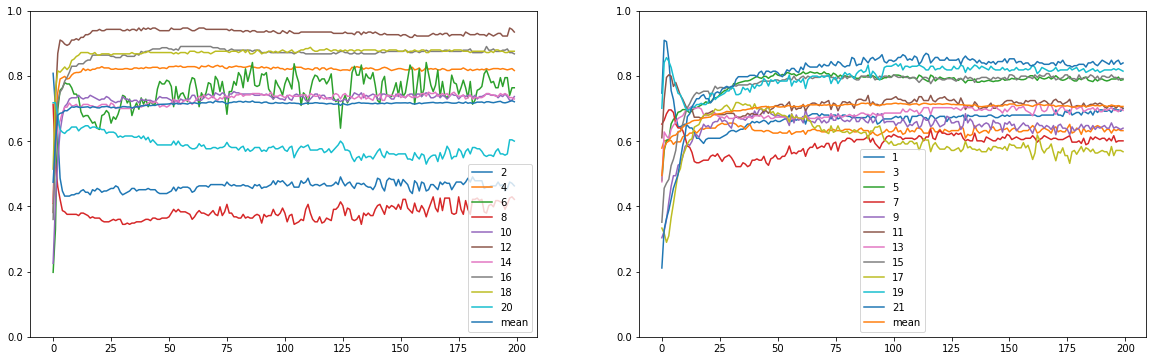

In [8]:
df_e1 = pd.read_csv(f'./results/hito1-empresa_1.csv')
df_e1["mean"] = df_e1.mean(numeric_only=True, axis=1)

df_e2 = pd.read_csv(f'./results/hito1-empresa_2.csv')
df_e2["mean"] = df_e2.mean(numeric_only=True, axis=1)

print(f'Acc máximo empresa 1: {df_e1["mean"].max()}')
print(f'Acc máximo empresa 2: {df_e2["mean"].max()}')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))

df_e1.plot(ax=ax1, ylim=(0,1))
df_e2.plot(ax=ax2, ylim=(0,1))